In [1]:
import sys
sys.path.append('..')
import json
import help_functions as hf
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import pandas as pd
hf.setup_gpu(gpu_nr=1)

2 Physical GPUs, 1 Logical GPU


In [2]:
with open('training_configurations.json', 'r') as fp:
    config = json.load(fp)[str(1)]

config['nr_classes'] = 20
test = hf.get_flow(df_file=config['data_folder'] + '/test_df.json.bz2',
                   nr_classes=config['nr_classes'],
                   batch_size=config['batch_size'],
                   image_dimension=config['image_dimension'])
y_true = hf.get_y_true(shape=(test.samples, len(test.class_indices)), classes=test.classes)
label_names = list(test.class_indices.keys())

Found 50000 non-validated image filenames belonging to 40 classes.


/home/matvieir/wiki_image_classification/src/classification/help_functions.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_labels['labels'] = df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


Found 49514 validated image filenames belonging to 20 classes.


ERROR: Could not save image results_thesis/1_random_initialization__bs_512/oversampled_imbalance_ratios.png
Found 50000 non-validated image filenames belonging to 40 classes.


/home/matvieir/wiki_image_classification/src/classification/help_functions.py:264: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_labels['labels'] = df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])
<ipython-input-3-d3afd29e7760>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append([test_df.loc[index_to_duplicate]] * times_to_duplicate, ignore_index=False)
<ipython-input-3-d3afd29e7760>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append([test_df.loc[index_to_duplicate]] * times_

Found 59417 non-validated image filenames belonging to 20 classes.
Found 59417 validated image filenames belonging to 20 classes.


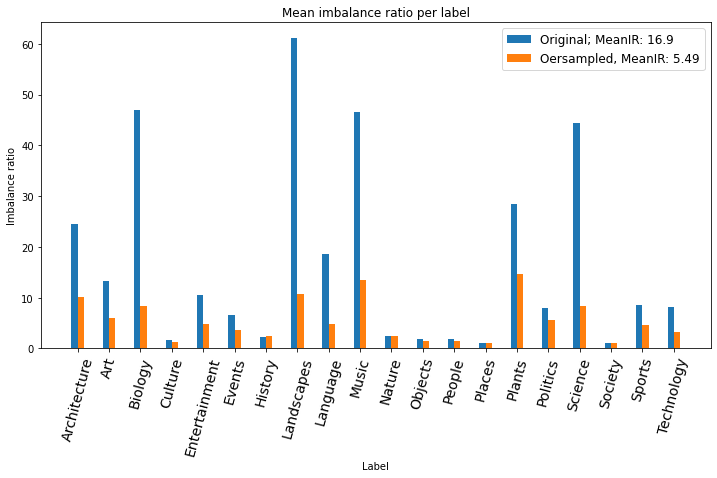

In [3]:
y_true = hf.get_y_true(shape=(test.samples, len(test.class_indices)), classes=test.classes)
duplicate_indices_dict = hf.oversample(y_true, list(test.class_indices.keys()), 0.2, config['results_folder'])
test_df = hf.clean_df_and_keep_top_classes(config['data_folder'] + '/test_df.json.bz2', config['nr_classes']).reset_index()
for index_to_duplicate in duplicate_indices_dict:
    times_to_duplicate = duplicate_indices_dict[index_to_duplicate]
    test_df = test_df.append([test_df.loc[index_to_duplicate]] * times_to_duplicate, ignore_index=False)
test_df = test_df.reset_index() # not necessary but why not
test = hf.get_flow(df=test_df,
                    nr_classes=config['nr_classes'],
                    image_dimension=config['image_dimension'])

In [33]:
def oversample(y_true, label_names, add_pctg, image_path):
    """
    Lets each image have a reward (reward := sum of label rewards in the image, where 
    label_reward := BIG_NUMBER / label_samples). An image will have high reward when 
    it has rare labels, and small rewards when it has frequent labels.

    Output:
        - indices_to_add: a list of the indices to be duplicated and the amount of times 
    """

    add_pctg = 0.2
    mean_ir_original, dict_ir_original = hf.mean_imbalance_ratio(y_true=y_true, class_names=label_names)

    original_nr_rows = y_true.shape[0]
    nr_labels = y_true.shape[1]
    y_true_copy = np.copy(y_true)
    indices_to_add = []

    BIG_NUMBER = 40_000
    label_rewards = BIG_NUMBER / y_true_copy.sum(axis=0)
    row_rewards = (label_rewards * y_true_copy).sum(axis=1)

    while y_true_copy.shape[0] < original_nr_rows * (1 + add_pctg):
        best_row = y_true_copy[np.argmax(row_rewards), :].reshape(1, nr_labels)
        y_true_copy = np.append(y_true_copy, best_row, axis=0)
        label_rewards = BIG_NUMBER / y_true_copy.sum(axis=0)
        row_rewards = (label_rewards * y_true_copy).sum(axis=1)
        idx_to_add = np.where((y_true == best_row).all(axis=1))[0]
        indices_to_add.append(idx_to_add)

    mean_ir_heuristics, dict_ir_heuristics = hf.mean_imbalance_ratio(y_true=y_true_copy, class_names=label_names)

    plt.figure(figsize=(12, 6))
    x_axis = np.arange(len(dict_ir_original.keys()))
    plt.bar(x_axis-0.1, dict_ir_original.values(), width=0.2, label=f'Original; macro-avg: {np.round(mean_ir_original, 1)}')
    plt.bar(x_axis+0.1, dict_ir_heuristics.values(), width=0.2, label=f'Undersampled, macro-avg: {np.round(mean_ir_heuristics, 2)}')
    plt.legend(fontsize=12)
    _ = plt.xticks(x_axis, dict_ir_heuristics.keys(), rotation=75, fontsize=14)
    plt.title('Mean imbalance ratio per label')
    plt.ylabel('Imbalance ratio')
    plt.xlabel('Label')
    hf.save_img(image_path + '/imbalance_ratios.png')

    indices_to_add_hashable = [tuple(el) for el in indices_to_add]
    duplicate_indices_dict = dict(Counter(indices_to_add_hashable))
    duplicate_indices_dict = dict((key[0], value) for (key, value) in duplicate_indices_dict.items())    
    return duplicate_indices_dict

ERROR: Could not save image /imbalance_ratios.png


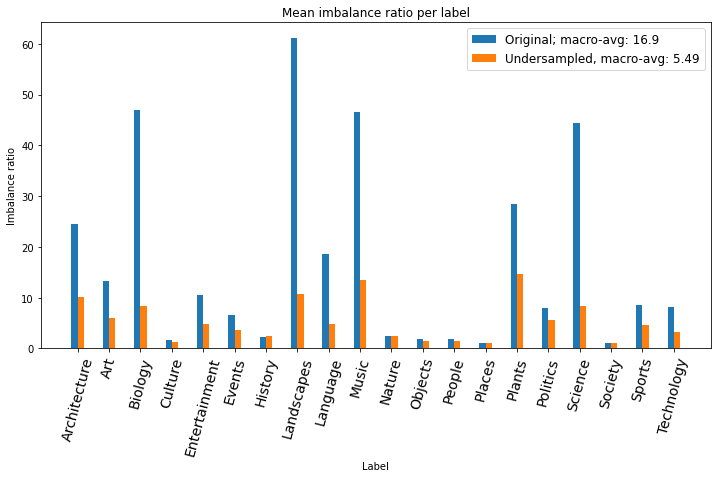

In [35]:
duplicate_indices_dict = oversample(y_true, label_names, 0.2, '')

In [36]:
df = hf.clean_df_and_keep_top_classes(config['data_folder'] + '/test_df.json.bz2', config['nr_classes']).reset_index()

Found 50000 non-validated image filenames belonging to 40 classes.


/home/matvieir/wiki_image_classification/src/classification/help_functions.py:264: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_labels['labels'] = df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


In [ ]:
for index_to_duplicate in duplicate_indices_dict:
    times_to_duplicate = duplicate_indices_dict[index_to_duplicate]
    # print(f'index_to_duplicate: {index_to_duplicate};\n times_to_duplicate: {times_to_duplicate}')
    df = df.append([df.loc[index_to_duplicate]] * times_to_duplicate, ignore_index=False)
